<a href="https://colab.research.google.com/github/threegenie/sentiment_project/blob/main/sentiment_project_using_okt_and_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## RandomForest, Logistic regression 모델을 사용하여 감성분석 해보기 try try

In [1]:
! pip install konlpy

In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (5,544 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 160772 files and d

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
#mpl.font_manager._rebuild()

# https://pinkwink.kr/1255 / https://teddylee777.github.io/colab/colab-korean 한글 문제 대응 참고

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
# 오류(SettingWithCopyError 발생)
pd.set_option('mode.chained_assignment', 'raise') # SettingWithCopyError

# 경고(SettingWithCopyWarning 발생, 기본 값입니다)
pd.set_option('mode.chained_assignment', 'warn') # SettingWithCopyWarning

# 무시
pd.set_option('mode.chained_assignment',  None) # <==== 경고를 끈다

In [6]:
df = pd.read_table('review.txt', names=['ratings', 'reviews'])
df

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ
...,...,...
199995,2,장마라그런가!!! 달지않아요
199996,5,다이슨 케이스 구매했어요 다이슨 슈퍼소닉 드라이기 케이스 구매했어요가격 괜찮고 배송...
199997,5,로드샾에서 사는것보다 세배 저렴하네요 ㅜㅜ 자주이용할께요
199998,5,넘이쁘고 쎄련되보이네요~


#### 중복 데이터가 있다면 제거

In [7]:
df.drop_duplicates('reviews',keep='first')
df.shape

(200000, 2)

중복 데이터가 없다.

#### 별이 3개인 어중간한 데이터 제거

In [8]:
three = df[df['ratings']==3].index
df = df.drop(three)
df.shape

(200000, 2)

별 3개인 데이터가...없다...?!

#### 훈련, 테스트셋 분리

In [9]:
train, val = train_test_split(df, test_size = 0.2, random_state = 11)
train.shape, val.shape

((160000, 2), (40000, 2))

#### 별점으로 라벨링 : 별점이 4을 넘으면 긍정 리뷰, 이하는 부정 리뷰로 분류

In [10]:
def star_evaluate(rating):
  if rating >=4:
    return 1
  else:
    return 0
  
train['label'] = train['ratings'].apply(star_evaluate)
val['label'] = val['ratings'].apply(star_evaluate)
train

,ratings,reviews,label
6173,5,머리끝이 많이 갈라져서 구매했습니다. 이미 갈라진 건 어쩔 수 없지만 뭔가 모발이 ...,1
62572,4,"가방사이즈 딱 적절해서 좋고, 탄탄한 느낌이라 좋네요. 다만 새것 냄새가 2일째 빠...",1
102317,2,생각보다 짧아요 ㅠ,0
122006,2,별로따뜻하지도않고..벨브도돌리다밑에캡이빠져버리네여..ㅡㅡ그래서본드로붙였는데..노즐만...,0
111083,1,마스크는소형인데끈이대형이네요ㅎ 그것도 쉽게 끊어져요ㅜ,0
...,...,...,...
102327,1,완전 잘깨져요 이건 뭐 잠깐 바닥에 스치기만해도 깨져있어요,0
97617,2,바코드안떳어요,0
21584,2,네조아요. 필요해서 샀어요,0
36543,5,발열 엄청 오래 지속되고 냄새도 없고 만족합니다,1


In [11]:
train['label'].value_counts()

0    80157
1    79843
Name: label, dtype: int64

#### 데이터 정제 - 훈련, 테스트셋에 모두 적용 -> 정규표현식 사용하여 한글 제외 모두 제거

In [12]:
train['reviews'] = train['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train['reviews'].replace('', np.nan, inplace=True)
train.head()

,ratings,reviews,label
6173,5,머리끝이 많이 갈라져서 구매했습니다 이미 갈라진 건 어쩔 수 없지만 뭔가 모발이 더...,1
62572,4,가방사이즈 딱 적절해서 좋고 탄탄한 느낌이라 좋네요 다만 새것 냄새가 일째 빠지지 ...,1
102317,2,생각보다 짧아요 ㅠ,0
122006,2,별로따뜻하지도않고벨브도돌리다밑에캡이빠져버리네여ㅡㅡ그래서본드로붙였는데노즐만새로사야할듯...,0
111083,1,마스크는소형인데끈이대형이네요ㅎ 그것도 쉽게 끊어져요ㅜ,0


In [13]:
val['reviews'] = val['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
val['reviews'].replace('', np.nan, inplace=True)
val.head()

,ratings,reviews,label
126682,5,조립하기힘들었어요 나사가짧아서,1
64852,2,ㅜㅜ 제가 인데 ㅜㅜ 진짜 너무너무커요 빨으니까 더 커졌어요ㅜ 잠옷으로 입으려구요,0
139941,1,만족하는데 배송이 개느림,0
85091,5,허리받쳐주는건 좋은데 방석이 미끌어져서 뷸편하네용 ㅠ,1
61522,5,밥을 해도 압력이 안된 밥을 먹었는데 새 패킹으로 갈아끼우니 짱짱하네여내일부터는 밥...,1


#### 토큰화 - Okt 사용

In [14]:
from konlpy.tag import Okt
okt = Okt()

In [15]:
stopwords = ['요', '도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [16]:
train['tokenized'] = train['reviews'].apply(okt.morphs)
train['tokenized'] = train['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [17]:
val['tokenized'] = val['reviews'].apply(okt.morphs)
val['tokenized'] = val['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [18]:
train.head()

,ratings,reviews,label,tokenized
6173,5,머리끝이 많이 갈라져서 구매했습니다 이미 갈라진 건 어쩔 수 없지만 뭔가 모발이 더...,1,"[머리, 끝, 많이, 갈라져서, 구매, 했습니다, 이미, 갈라진, 건, 어쩔, 수,..."
62572,4,가방사이즈 딱 적절해서 좋고 탄탄한 느낌이라 좋네요 다만 새것 냄새가 일째 빠지지 ...,1,"[가방, 사이즈, 딱, 적절해서, 좋고, 탄탄한, 느낌, 이라, 좋네요, 다만, 새..."
102317,2,생각보다 짧아요 ㅠ,0,"[생각, 보다, 짧아요, ㅠ]"
122006,2,별로따뜻하지도않고벨브도돌리다밑에캡이빠져버리네여ㅡㅡ그래서본드로붙였는데노즐만새로사야할듯...,0,"[별로, 따뜻하지도, 않고, 벨브, 돌리다, 밑, 캡, 빠져, 버리네, 여, ㅡㅡ,..."
111083,1,마스크는소형인데끈이대형이네요ㅎ 그것도 쉽게 끊어져요ㅜ,0,"[마스크, 소형, 인데, 끈, 이대형, 이네, ㅎ, 그것, 쉽게, 끊어져요, ㅜ]"


#### 데이터에 정수 인코딩

In [19]:
X_train = train['tokenized']
y_train = train['label']
X_val= val['tokenized']
y_val = val['label']

In [20]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [21]:
threshold = 2
total_cnt = len(tokenizer.word_index) 
rare_cnt = 0 
total_freq = 0 
rare_freq = 0 

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 97950
등장 빈도가 1번 이하인 희귀 단어의 수: 54340
단어 집합에서 희귀 단어의 비율: 55.47728432873915
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.757317496432841


In [22]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 43612


In [23]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_val= tokenizer.texts_to_sequences(X_val)

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


리뷰의 최대 길이 : 59
리뷰의 평균 길이 : 12.317225


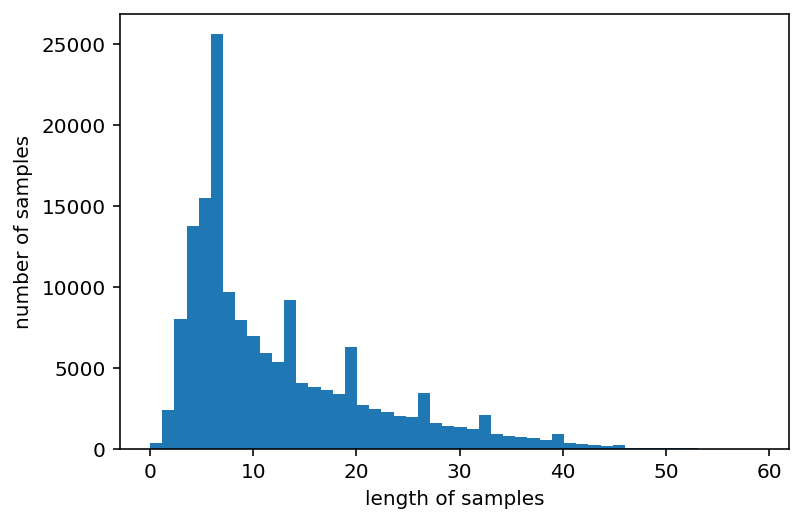

In [24]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [25]:
max_len = 80 #Padding 80으로
X_train = pad_sequences(X_train, maxlen = max_len)
X_val = pad_sequences(X_val, maxlen = max_len)


#### Random Forest Model 

In [26]:
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics

In [27]:
model = RandomForestClassifier(n_estimators=500
                             , random_state=11)

In [28]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=11, verbose=0,
                       warm_start=False)

#### Accuracy score

In [29]:
y_pred = model.predict(X_val)
accuracy_score(y_val, y_pred)

0.697875

In [30]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.75      0.71     19880
           1       0.72      0.65      0.68     20120

    accuracy                           0.70     40000
   macro avg       0.70      0.70      0.70     40000
weighted avg       0.70      0.70      0.70     40000



#### Predict

In [31]:
def sentiment_predict_rf(sentence):
  sentence = okt.morphs(sentence) # 토큰화
  sentence = [word for word in sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [32]:
sentiment_predict_rf('좋았습니다 주문을 미루고 미루다보니 시간이 급해서 당일제작 옵션 선택해서 진행했습니다.')

100.00% 확률로 부정 리뷰입니다.


In [33]:
sentiment_predict_rf('재질도 좋고 색감도 예뻐요 만족스러워서 서랍장 하나 더 구매했습니다')

100.00% 확률로 긍정 리뷰입니다.


In [35]:
sentiment_predict_rf('라면 냄비로 구입 했었는데 제가 생각 했던것보다 많이 작았네요')

100.00% 확률로 긍정 리뷰입니다.


In [37]:
sentiment_predict_rf('최악이다 기포 안없어져서 다시 뜯었는데 그대로 굳었어 ㅋ')

100.00% 확률로 부정 리뷰입니다.


random forest 모델을 이용했을 때 정확도는 높지만, 감성 분석이 제대로 되지 않는 것을 알 수 있다.. 왜이러징 그러니까 앞으로도 GRU를 이용하자!^^

#### Logistic Regression

In [38]:
logistic = LogisticRegression()
logistic.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [39]:
y_pred = logistic.predict(X_val)
accuracy_score(y_val, y_pred)

0.52675

In [40]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.92      0.66     19880
           1       0.64      0.14      0.22     20120

    accuracy                           0.53     40000
   macro avg       0.58      0.53      0.44     40000
weighted avg       0.58      0.53      0.44     40000



In [41]:
def sentiment_predict_lg(sentence):
  sentence = okt.morphs(sentence) # 토큰화
  sentence = [word for word in sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(logistic.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [42]:
sentiment_predict_lg('좋았습니다 주문을 미루고 미루다보니 시간이 급해서 당일제작 옵션 선택해서 진행했습니다.')

100.00% 확률로 부정 리뷰입니다.


In [43]:
sentiment_predict_lg('재질도 좋고 색감도 예뻐요 만족스러워서 서랍장 하나 더 구매했습니다')

100.00% 확률로 부정 리뷰입니다.


In [45]:
sentiment_predict_lg('라면 냄비로 구입 했었는데 제가 생각 했던것보다 많이 작았네요')

100.00% 확률로 부정 리뷰입니다.


In [46]:
sentiment_predict_lg('최악이다 기포 안없어져서 다시 뜯었는데 그대로 굳었어 ㅋ')

100.00% 확률로 부정 리뷰입니다.
